# New Section

In [ ]:
#Do not run
#Format of input?
#2D input array into keras
#!pip install --target=$nb_path moabb
#!pip3 install --target=$nb_path torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install --target=$nb_path braindecode
#!pip install --target=$nb_path mne
#!pip install --target=$nb_path -U https://api.github.com/repos/braindecode/braindecode/zipball/master
#!pip install --target=$nb_path git+https://github.com/forrestbao/pyeeg.git
#!pip install eeglib

!pip install -U scipy

In [ ]:

import os, sys
from google.colab import drive
drive.mount('/content/drive')
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)


#4/1AX4XfWhv3cBxSin7WYEfMUa4vnyi5O4Cx-MYYR-hW-PeCAYZQBj7CH1b248

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileExistsError: ignored

In [ ]:
import io
from google.colab import files
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json



sys.path.insert(0,nb_path)

import cv2
from PIL import Image
from numpy import asarray
import matplotlib
import pathlib
import mne
import scipy

import pyeeg
import eeglib
import random
from scipy import linalg
import scipy.stats
from mne.preprocessing import ICA

def integers(a, b):
         return list(range(a, b+1))

rawlist = integers(7,7)
mainpath = "/content/drive/My Drive/RawEEG_M5/"

In [ ]:
filexist = False
filexist = True
savefile = pd.read_csv(r"/content/drive/My Drive/raw_pyeeg/data.csv",header = 0,index_col = 0)

!rm -rf "/content/drive/My Drive/raw_pyeeg"
!mkdir "/content/drive/My Drive/raw_pyeeg"

for i in rawlist:
  order = str(i)+"/"
  subpath = os.path.join(mainpath,order)

  ################################################
  output_fname = "Heart rate"+".xlsx"
  data_file = os.path.join(subpath, output_fname )
  dump = pd.ExcelFile(data_file)
  HeartRate = dump.parse("Heart rate")

  OutputData = pd.DataFrame(HeartRate["Heart rate"])

  if (HeartRate["TimeStamp"].size < 1):
    continue
  #################################################
  obci_fname = 'raw.txt'
  data_file = os.path.join(subpath, obci_fname )

  channel_names = ['Fp1', 'Fp2', 'C3', 'C4', 'T5', 'T6', 'O1','O2']
  channel_types = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg','eeg']
  sfreq = 250  # in Hertz
  montage = 'standard_1020'

  info = mne.create_info(channel_names, sfreq, channel_types)

  n_channels = 8
  sampling_rate = 250
  #info = mne.create_info(n_channels, sampling_rate)
  print(info)

  counter = 0
  window_ = 5
  jumpstep_ = 3
  InputData = []
  OutputData = {}
  queue = {}
  sum_ = {}
  data_arr = np.empty((0, 8))
  time = 0
  timein = 0
  eeg_id = ["1","2","3","4","5","6","7","8"]
  dummy = np.empty((1, 8))
  id = np.zeros((340,1))
  inlen = 0


  #############################################

  _Tau = 2 #in fisher_info
  _DE = 20 #in fisher_info
  _Band = [0.5,4,7,12,30] #bin_power
  _Freq = 250
  _M  = 2  #ap_en and sa_en 
  #_R =  std(time_series)/4    for ap_en and sa_en

  sphere_not_define = True
  def createList(n):
      lst = []
      for i in range(n+1):
          lst.append(i)
      return(lst)
  newraw = np.empty((9, 10000000))
  newraw_l = 0
  with open( data_file, 'r' ) as in_f:
      header = True
      while header:
          line = next( in_f )
          if line[0] != '%':
              header = False
      dump = True
      for line in in_f:
          temp = np.array(line.strip( ' \n' ).split( ', ' )[1:23]).astype(np.float)
          newraw[0][newraw_l] = temp[0]
          newraw[1][newraw_l]  = temp[1]
          newraw[2][newraw_l]  = temp[2]
          newraw[3][newraw_l]  = temp[3]
          newraw[4][newraw_l]  = temp[4]
          newraw[5][newraw_l]  = temp[5]
          newraw[6][newraw_l]  = temp[6]
          newraw[7][newraw_l]  = temp[7]
          newraw[8][newraw_l]  = temp[21]
          newraw_l += 1

      newraw = mne.filter.filter_data(newraw[:,0:newraw_l], sfreq, 0.5, 70, picks=createList(7))
      newraw = mne.filter.notch_filter(newraw, sfreq, 50, picks=createList(7))
              
      time_arr = newraw[8]
      
      custom_raw = mne.io.RawArray(newraw[0:8,0:newraw_l], info)
      custom_raw.set_montage('standard_1020')

      ica = ICA(n_components=8, max_iter='auto', random_state=123)
      ica.fit(custom_raw)
      ica.apply(custom_raw)

      if (sphere_not_define):
                sphere = mne.make_sphere_model('auto', 'auto', custom_raw.info)
                src = mne.setup_volume_source_space(sphere=sphere, exclude=30., pos=15.)
                forward = mne.make_forward_solution(custom_raw.info, trans=None, src=src, bem=sphere)
                sphere_not_define = False

      custom_raw.set_eeg_reference(ref_channels='REST',forward=forward)

      newraw = np.vstack((custom_raw._data,time_arr[np.newaxis,:]))

      del custom_raw

      for temp in range(newraw_l):
          #np.vstack((data_arr,np.array( line.strip( ' \n' ).split( ', ' )[1:9] )))
          #np.insert(X, 0, 6., axis=0)
          if (dump):
              dump = False
          else:
              #temp = np.array(line.strip( ' \n' ).split( ', ' )[1:23]).astype( np.float )
              time = newraw[8][temp] 
          if (time < HeartRate["TimeStamp"][timein]):
              continue
          if (time > (HeartRate["TimeStamp"][timein]+5)):
              counter = 0
              timein += 1      
              data_arr = np.empty((0, 8))
              continue
          counter = counter + 1
          for x in range(8):
            dummy[:,x] = newraw[x][temp]
          data_arr = np.vstack((data_arr,dummy))
            
          if (counter == 4*256):
              data_arr = data_arr.T
              
              #for y in range(4*256):
              #    data_arr[:,y] = data_arr[:,y] - mean(data_arr[:,y])
              
              #data_arr = data_arr - mean(data_arr, 1)

              target = HeartRate["Heart rate"][timein]

              datasets = []
              #save_concat_dataset("/content/drive/My Drive/raw_braindecode", windows_dataset)

              #custom_raw.filter(0.5, 70)
              #custom_raw.notch_filter(60)
              
            

              raw_ = data_arr
              print(raw_.shape)
              #custom_raw.set_eeg_reference(ref_channels='average')

              #custom_raw.resample(60)

              data_arr = np.empty((0, 8))
              frame = np.empty((0))
              for X in raw_:

                  std = np.std(X)
                  mean = np.mean(X)
                  #fft = np.fft.fft(X)

                  skew = scipy.stats.skew(X, axis=0, bias=True)
                  kurtosis = scipy.stats.kurtosis(X, axis=0, fisher=True, bias=True)

                  R = std/4                
                  ap_en = pyeeg.ap_entropy(X,_M,R)
                  sa_en = pyeeg.samp_entropy(X,_M,R)
                  D = np.diff(X).tolist()
                  M = pyeeg.embed_seq(X,_Tau,_DE)
                  W = linalg.svd(M, compute_uv=0)
                  W /= sum(W)
                  bin = pyeeg.bin_power(X,_Band,_Freq)
                  df = pyeeg.dfa(X)
                  hj = pyeeg.hjorth(X,D=D)
                  hu = pyeeg.hurst(X)
                  pf = pyeeg.pfd(X,D=D)
                  sv_en = pyeeg.svd_entropy(X,_Tau,_DE,W=W)
                  fi = pyeeg.fisher_info(X,_Tau,_DE,W=W)
                  sp_en = pyeeg.spectral_entropy(X,_Band,_Freq, Power_Ratio=bin)

                  hf = eeglib.features.HFD(X)
                  lz = eeglib.features.LZC(X)
                  SigC = eeglib.features.countSignChanges(X)
                  ha = eeglib.features.hjorthActivity(X)

                  #bin 2D
                  #hj 1D
                  #sp_en 1D

                  """
                  List of features extracted:

                  Standard deviation
                  Mean
                  Skewness
                  Kurtosis
                  Detrended Fluctuation Analysis
                  Hurst exponent
                  Petrosian Fractal Dimension
                  SVD Entropy
                  Fisher information
                  Lempel-Ziv Complexity (LZ76)
                  number of sign changes
                  Higuchi Fractal Dimension 
                  Approximate entropy
                  Sample entropy
                  Hjorth Activity
                  Hjorth mobility
                  Hjorth complexity
                  Spectral entropy of each band in 4 bands
                  Normalized spectral power of each band in 4 bands
                  (FFT and spectrogram are not included directly due to size but spectral information is included)
                  """
                  temp1 = np.array([std,mean,skew,kurtosis,df,hu,pf,sv_en,fi,lz,SigC,hf,ap_en,sa_en,ha])

                  bin = np.asarray(bin).flatten()
                  temp2 = np.concatenate((np.asarray(hj),np.asarray(sp_en)))
                  temp2 = np.concatenate((temp2,bin[4:8]))
                  temp = np.concatenate((temp1,temp2))
                  frame = np.concatenate((frame,temp))

              frame = np.concatenate((frame,np.array([target])))
              '''status = random.randint(1, 10)
              
              if (status < 9 ):
                f_descrition = pd.Series(
                  data=[target, "train"],
                  index=["target", "session"])
              else:
                f_descrition = pd.Series(
                  data=[target, "test"],
                  index=["target", "session"])
              base_ds = BaseDataset(custom_raw, f_descrition, target_name="target")
              datasets.append(base_ds)
              InputData = BaseConcatDataset(datasets)'''
              if (filexist):
                savefile = pd.concat([savefile, pd.DataFrame(frame)], axis=1)
                #savefile.append(pd.DataFrame(frame))
                print(savefile.shape)
              else: 
                savefile = pd.DataFrame(frame)
                filexist = True
              timein += 1
              if (timein > HeartRate["Heart rate"].size):
                break
              data_arr = np.empty((0, 8))
              counter = 0
savefile.to_csv("/content/drive/My Drive/raw_pyeeg/data.csv")

  #apply Z score later in preprocessing before training


In [ ]:
print(savefile)

               0         0.1         0.2  ...      0.2186      0.2187      0.2188
0    5823.853768  656.594617  655.904547  ...  351.172189  187.290503  414.586456
1    -249.823056   38.928729   67.109964  ...    0.236634   57.598924   38.332252
2       0.185038   -0.005459    1.019770  ...    0.059989   -0.814112    0.269185
3       3.826038   -0.643657    3.663499  ...    4.635936    3.827633   -0.640983
4       0.378187    1.313193    1.214182  ...    0.115322    1.309846    1.503869
..           ...         ...         ...  ...         ...         ...         ...
196     0.575957    0.567317    0.485208  ...    0.284189    0.484767    0.701534
197     0.191336    0.215619    0.164347  ...    0.062446    0.072589    0.068783
198     0.096103    0.102355    0.183520  ...    0.069510    0.087561    0.057473
199     0.136603    0.114709    0.166925  ...    0.583854    0.355084    0.172210
200    60.000000   60.000000   59.000000  ...   52.000000   51.000000   52.000000

[201 rows x 400

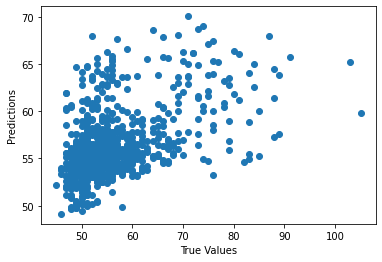

RandomForestRegressor(n_estimators=750, random_state=333)
0.2360234313906181


In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.tree import export_graphviz 
from sklearn.metrics import mean_squared_error
import graphviz 
import operator
import math



savefile = pd.read_csv("/content/drive/My Drive/raw_pyeeg/data.csv",header = 0,index_col = 0)
#savefile = savefile.drop(savefile.columns[[0]], inplace=True, axis = 1)
print(savefile)

SourceData_train_independent = savefile.drop(200).T
print(SourceData_train_independent.shape)
SourceData_train_dependent= savefile.iloc[200]
print(SourceData_train_dependent.shape)

sc_X = StandardScaler()

y_train=SourceData_train_dependent 
X_train= SourceData_train_independent

#X_train=sc_X.fit_transform(X_train.values) 

X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,train_size = 0.8, test_size=0.2, random_state = 444)
reg = RandomForestRegressor(max_depth=None, random_state=333, n_estimators=750).fit(X_train, y_train)
    
predictions = reg.predict(X_test)
plt.scatter(y_test,predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
print(".")
plt.show()
print(reg)
importances = reg.feature_importances_
print(r2_score(y_test,predictions))

In [ ]:
print(savefile)
print(str(8)+"/")